# Projet 8

In [1]:
train_mode = True

Je commence par définir le drapeau `train_mode`. Lorsqu'il est à `True`, je documente seulement le pipeline sans lancer les entraînements coûteux ; je peux ainsi expliquer chaque étape sans surcharger l'environnement.

In [2]:
# --- Simple dataset scanner (counts only, no filenames, no JSON) ---
from pathlib import Path
import os
from collections import Counter

# >>> Change this to your dataset root (WSL path) <<<
ROOT = Path("../data")

IGNORE_HIDDEN = True       # ignore .git, __pycache__, etc.
MAX_DIRS_TO_SHOW = 80      # limit directory lines for readability

total_files = 0
total_dirs = 0
by_ext = Counter()
by_dir = {}

for dirpath, dirnames, filenames in os.walk(ROOT):
    # optionally hide hidden/internal dirs
    if IGNORE_HIDDEN:
        dirnames[:] = [d for d in dirnames if not d.startswith(".") and not d.startswith("__")]
    total_dirs += 1
    rel = Path(dirpath).relative_to(ROOT) if Path(dirpath) != ROOT else Path(".")
    by_dir[str(rel)] = len(filenames)
    for fn in filenames:
        by_ext[Path(fn).suffix.lower()] += 1
    total_files += len(filenames)

print(f"[ROOT] {ROOT}")
print(f"dirs={total_dirs:,}  files={total_files:,}\n")

print("By extension (top 10):")
for ext, n in by_ext.most_common(10):
    print(f"  {ext or '(no ext)'}: {n:,}")
print()

print(f"Directory counts (first {MAX_DIRS_TO_SHOW}):")
for i, (rel, n) in enumerate(sorted(by_dir.items())):
    if i >= MAX_DIRS_TO_SHOW:
        print("  ... (truncated)")
        break
    print(f"  {rel}: {n}")

# -------- Cityscapes mini-summary (counts only) --------
def count_pattern(base: Path, split: str, suffix: str) -> int:
    split_dir = base / split
    total = 0
    if split_dir.exists():
        for city_dir in split_dir.iterdir():
            if city_dir.is_dir():
                total += sum(1 for p in city_dir.iterdir()
                             if p.is_file() and p.name.endswith(suffix))
    return total

print("\n[Cityscapes summary]")
for split in ("train", "val", "test"):
    gt_base = ROOT / "gtFine"
    left_base = ROOT / "leftImg8bit"
    label = count_pattern(gt_base, split, "_gtFine_labelIds.png")
    color = count_pattern(gt_base, split, "_gtFine_color.png")
    inst  = count_pattern(gt_base, split, "_gtFine_instanceIds.png")
    poly  = count_pattern(gt_base, split, "_gtFine_polygons.json")
    left  = count_pattern(left_base, split, "_leftImg8bit.png")
    print(f"  {split:5s}: leftImg8bit={left:6d}  labelIds={label:6d}  color={color:6d}  instanceIds={inst:6d}  polygons.json={poly:6d}")


[ROOT] ../data
dirs=63  files=25,000

By extension (top 10):
  .png: 20,000
  .json: 5,000

Directory counts (first 80):
  .: 0
  gtFine: 0
  gtFine/test: 0
  gtFine/test/berlin: 2176
  gtFine/test/bielefeld: 724
  gtFine/test/bonn: 184
  gtFine/test/leverkusen: 232
  gtFine/test/mainz: 1192
  gtFine/test/munich: 1592
  gtFine/train: 0
  gtFine/train/aachen: 696
  gtFine/train/bochum: 384
  gtFine/train/bremen: 1264
  gtFine/train/cologne: 616
  gtFine/train/darmstadt: 340
  gtFine/train/dusseldorf: 884
  gtFine/train/erfurt: 436
  gtFine/train/hamburg: 992
  gtFine/train/hanover: 784
  gtFine/train/jena: 476
  gtFine/train/krefeld: 396
  gtFine/train/monchengladbach: 376
  gtFine/train/strasbourg: 1460
  gtFine/train/stuttgart: 784
  gtFine/train/tubingen: 576
  gtFine/train/ulm: 380
  gtFine/train/weimar: 568
  gtFine/train/zurich: 488
  gtFine/val: 0
  gtFine/val/frankfurt: 1068
  gtFine/val/lindau: 236
  gtFine/val/munster: 696
  leftImg8bit: 0
  leftImg8bit/test: 0
  leftImg8bit/t

Je réalise ensuite un scan rapide du dossier de données pour vérifier que la hiérarchie Cityscapes est bien en place. Cette boucle `os.walk` me donne le volume de fichiers par extension et par dossier, ce qui permet de détecter tout oubli de téléchargement ou problème de nommage avant d'aller plus loin.

In [3]:
from pathlib import Path

ROOT = Path("../data")  # adapte si besoin
SUF_LEFT = "_leftImg8bit.png"
SUF_LBL  = "_gtFine_labelIds.png"

def base_id(name: str) -> str:
    return name[:-len(SUF_LEFT)] if name.endswith(SUF_LEFT) else name[:-len(SUF_LBL)]

def split_counts(split: str):
    left_dir = ROOT / "leftImg8bit" / split
    lbl_dir  = ROOT / "gtFine"      / split
    left = sorted(left_dir.rglob(f"*{SUF_LEFT}")) if left_dir.exists() else []
    lbl  = sorted(lbl_dir.rglob (f"*{SUF_LBL}" )) if lbl_dir.exists()  else []
    left_ids = {base_id(p.name) for p in left}
    lbl_ids  = {base_id(p.name) for p in lbl}
    paired = left_ids & lbl_ids
    print(f"{split:<5} | left={len(left):4d}  labels={len(lbl):4d}  paired={len(paired):4d}")

for sp in ("train", "val", "test"):
    split_counts(sp)



train | left=2975  labels=2975  paired=2975
val   | left= 500  labels= 500  paired= 500
test  | left=1525  labels=1525  paired=1525


Cette cellule contrôle que chaque image RGB possède bien son masque d'annotations associé pour les splits *train/val/test*. Je reconstruis les identifiants de fichiers avec `base_id` et compare les ensembles afin d'anticiper toute incohérence de couplage.

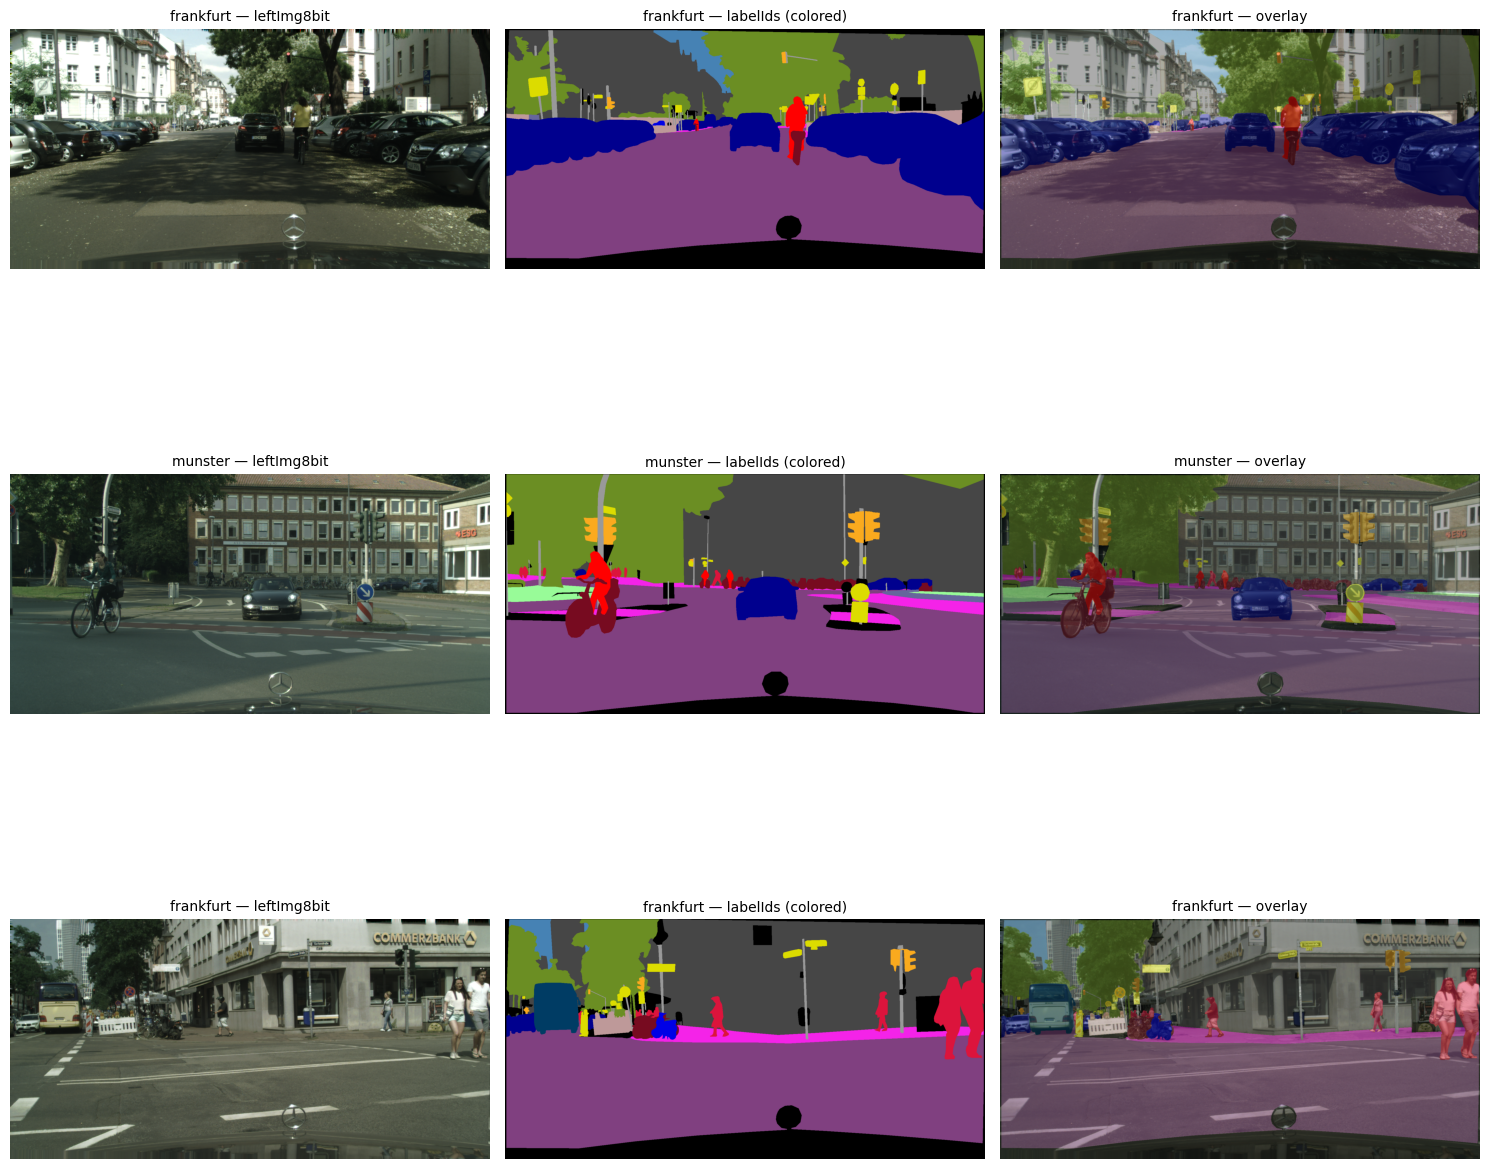

In [4]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

ROOT = Path("../data")

PALETTE = {
    7:(128,64,128), 8:(244,35,232), 11:(70,70,70), 12:(102,102,156), 13:(190,153,153),
    17:(153,153,153), 19:(250,170,30), 20:(220,220,0), 21:(107,142,35), 22:(152,251,152),
    23:(70,130,180), 24:(220,20,60), 25:(255,0,0), 26:(0,0,142), 27:(0,0,70),
    28:(0,60,100), 31:(0,80,100), 32:(0,0,230), 33:(119,11,32),
}

def pairs(split="val"):
    lbls = sorted((ROOT/"gtFine"/split).rglob("*_gtFine_labelIds.png"))
    out = []
    for lp in lbls:
        stem = lp.name.replace("_gtFine_labelIds.png", "")
        city = lp.parent.name
        left = ROOT/"leftImg8bit"/split/city/(stem+"_leftImg8bit.png")
        if left.exists():
            out.append((left, lp))
    return out

def colorize(ids: np.ndarray) -> Image.Image:
    h, w = ids.shape
    rgb = np.zeros((h, w, 3), np.uint8)
    for k, c in PALETTE.items():
        rgb[ids == k] = c
    return Image.fromarray(rgb, "RGB")

def overlay(img: Image.Image, mask_rgb: Image.Image, alpha=0.5) -> Image.Image:
    a = np.asarray(img.convert("RGB"), np.float32)
    b = np.asarray(mask_rgb, np.float32)
    return Image.fromarray(np.clip((1-alpha)*a + alpha*b, 0, 255).astype(np.uint8))

samples = pairs("val")
assert samples, "No pairs found — check your paths."
random.shuffle(samples)
k = 3

plt.figure(figsize=(15, 5*k))
for i, (left_p, lbl_p) in enumerate(samples[:k]):
    left = Image.open(left_p).convert("RGB")
    ids  = np.array(Image.open(lbl_p))
    mask = colorize(ids)
    over = overlay(left, mask, alpha=0.45)
    for j, (img, title) in enumerate([(left,"leftImg8bit"),(mask,"labelIds (colored)"),(over,"overlay")]):
        ax = plt.subplot(k, 3, i*3 + j + 1)
        ax.imshow(img); ax.set_title(f"{left_p.parent.name} — {title}", fontsize=10); ax.axis("off")
plt.tight_layout(); plt.show()


Je construis ici un viewer minimaliste : pour quelques échantillons, j'ouvre l'image, le masque labelIds et je superpose les deux en utilisant la palette Cityscapes d'origine. Cela me permet de juger visuellement de la qualité des annotations et de confirmer que les chemins relatifs sont corrects.


### Remapping Cityscapes 32→8 classes

In [5]:
# --- 32→8 mapping (Cityscapes labelIds -> 8-class IDs), ignore = 255 ---
import numpy as np

CS_LABELID_TO_8 = {
    # 0..5 (voids) -> ignore by LUT fill (no need to list)
    6: 0,
    7: 0,  9: 0, 10: 0,           # road-like: road, parking, rail track
    8: 1,                         # sidewalk
    11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2,   # building + barriers
    17: 3, 18: 3, 19: 3, 20: 3,                 # traffic objs (pole/ts/tl)
    21: 4, 22: 4,                                 # vegetation + terrain
    23: 5,                                       # sky
    24: 6, 25: 6,                                 # person + rider
    26: 7, 27: 7, 28: 7, 29: 7, 30: 7, 31: 7, 32: 7, 33: 7,  # vehicles
}

def build_labelid_to8_lut(ignore_value: int = 255) -> np.ndarray:
    """Create a 256-entry LUT mapping Cityscapes labelIds -> {0..7} or 255(ignore)."""
    lut = np.full(256, ignore_value, dtype=np.uint8)
    for k, v in CS_LABELID_TO_8.items():
        lut[k] = v
    return lut

LUT_32TO8 = build_labelid_to8_lut(ignore_value=255)

def remap_labelids_to8(arr_uint16: np.ndarray) -> np.ndarray:
    """Vectorized remap of HxW labelIds (uint16/uint8) to 8-class IDs with 255 ignore."""
    arr = arr_uint16.astype(np.uint16)
    arr = np.minimum(arr, 255).astype(np.uint8)
    return LUT_32TO8[arr]


Je définis la table de correspondance qui convertit les 32 classes labelIds Cityscapes vers mes 8 classes cibles (avec 255 pour ignorer). Cette LUT est indispensable pour entraîner des modèles légers tout en conservant les informations essentielles.

In [6]:
PALETTE_8 = {
    0:(128,64,128),   # road
    1:(244,35,232),   # sidewalk
    2:(70,70,70),     # building+barrier
    3:(220,220,0),    # traffic objs
    4:(107,142,35),   # vegetation/terrain
    5:(70,130,180),   # sky
    6:(220,20,60),    # person+rider
    7:(0,0,142),      # vehicle
}


J'associe maintenant à chaque identifiant compressé une couleur RGB spécifique. Cette palette compacte me permettra d'afficher facilement les masques prédits ou transformés en 8 classes.

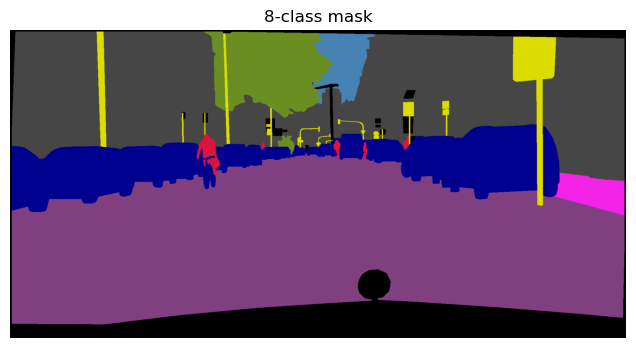

In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def colorize_8(label8: np.ndarray, palette: dict) -> Image.Image:
    h, w = label8.shape
    rgb = np.zeros((h, w, 3), np.uint8)
    for k, c in palette.items():
        rgb[label8 == k] = c
    return Image.fromarray(rgb, "RGB")

sample_lbl = next(Path("../data/gtFine/val/frankfurt").glob("*_gtFine_labelIds.png"))
arr = np.array(Image.open(sample_lbl))
arr8 = remap_labelids_to8(arr)
plt.figure(figsize=(8,4)); plt.imshow(colorize_8(arr8, PALETTE_8)); plt.axis("off"); plt.title("8-class mask"); plt.show()


Je rédige un petit module utilitaire : `colorize_8` transforme un masque d'étiquettes en image colorisée et `overlay_mask` facilite les superpositions masque/image. Ces fonctions sont réutilisées dans toutes les visualisations ultérieures.

In [8]:
import os

# ↓↓↓ Quieter TensorFlow logs (set BEFORE importing tf)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"     # 0=all, 1=INFO off, 2=INFO+WARNING off, 3=all off
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"  # avoid grabbing all GPU memory
# Optional: disable oneDNN (removes the "oneDNN custom ops are on" line, and tiny numeric diffs)
# os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import tensorflow as tf
from absl import logging as absl_logging
absl_logging.set_verbosity(absl_logging.ERROR)  # reduce absl spam

# (Optional) confirm GPU + set memory growth (extra safety)
gpus = tf.config.list_physical_devices("GPU")
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

print("TF:", tf.__version__, "| GPUs:", gpus)

# ==========================
# Cityscapes 32→8 remapping
# ==========================
import numpy as np

# 8 classes for embedded use (ignore=255):
# 0=road (7,9,10) | 1=sidewalk(8) | 2=building+barriers(11–16) | 3=traffic objs(17–20)
# 4=vegetation+terrain(21,22) | 5=sky(23) | 6=person+rider(24,25) | 7=vehicle(26–33)
CS_LABELID_TO_8 = {
    6:0,
    7:0, 9:0, 10:0,
    8:1,
    11:2, 12:2, 13:2, 14:2, 15:2, 16:2,
    17:3, 18:3, 19:3, 20:3,
    21:4, 22:4,
    23:5,
    24:6, 25:6,
    26:7, 27:7, 28:7, 29:7, 30:7, 31:7, 32:7, 33:7,
}

def build_labelid_to8_lut(ignore_value: int = 255) -> np.ndarray:
    lut = np.full(256, ignore_value, dtype=np.uint8)
    for k, v in CS_LABELID_TO_8.items():
        lut[k] = v
    return lut

LUT_32TO8 = build_labelid_to8_lut(ignore_value=255)
LUT_TF = tf.convert_to_tensor(LUT_32TO8, dtype=tf.uint8)  # shape [256]

# ===================
# Dataset (tf.data)
# ===================
from pathlib import Path
ROOT = Path("../data")               # <<< change if needed (WSL path)
INPUT_SIZE = (512, 1024)             # (H, W)
BATCH_SIZE = 4

SUF_LEFT = "_leftImg8bit.png"
SUF_LBL  = "_gtFine_labelIds.png"

def list_pairs(split: str):
    """Return two aligned lists: left paths and label paths for a given split."""
    lefts, labels = [], []
    lbl_root = ROOT / "gtFine" / split
    for lbl in sorted(lbl_root.rglob(f"*{SUF_LBL}")):
        city = lbl.parent.name
        stem = lbl.name.replace(SUF_LBL, "")
        left = ROOT / "leftImg8bit" / split / city / f"{stem}{SUF_LEFT}"
        if left.exists():
            lefts.append(str(left))
            labels.append(str(lbl))
    if not lefts:
        raise FileNotFoundError(f"No pairs found for split='{split}'. Check your paths under {ROOT}.")
    return lefts, labels

def decode_and_preprocess(left_path, lbl_path, training: bool):
    # 1) Read bytes
    left_bytes = tf.io.read_file(left_path)
    lbl_bytes  = tf.io.read_file(lbl_path)

    # 2) Decode
    img = tf.io.decode_png(left_bytes, channels=3)     # uint8 [H,W,3]
    lab = tf.io.decode_png(lbl_bytes,  channels=1)     # uint8/16 [H,W,1]

    # 3) To workable dtypes
    img = tf.image.convert_image_dtype(img, tf.float32)   # [0,1]
    lab = tf.cast(lab, tf.int32)                          # index dtype for LUT

    # 4) Remap 32→8 via LUT
    lab_clipped = tf.minimum(lab, 255)
    lab8 = tf.gather(LUT_TF, lab_clipped)                 # uint8 [H,W,1]
    lab8 = tf.squeeze(lab8, axis=-1)                      # uint8 [H,W]

    # 5) Simple augment (sync flip)
    if training:
        do_flip = tf.random.uniform(()) > 0.5
        img  = tf.cond(do_flip, lambda: tf.image.flip_left_right(img), lambda: img)
        lab8 = tf.cond(do_flip, lambda: tf.image.flip_left_right(lab8[..., None])[:, :, 0], lambda: lab8)

    # 6) Resize (labels in nearest, keep uint8)
    img  = tf.image.resize(img,  INPUT_SIZE, method="bilinear")
    lab8 = tf.cast(tf.image.resize(lab8[..., None], INPUT_SIZE, method="nearest")[:, :, 0], tf.uint8)

    # 7) Ignore handling → sample_weight (float32); labels safe (uint8→int32)
    ignore_val = tf.constant(255, dtype=tf.uint8)
    ignore = tf.equal(lab8, ignore_val)  # bool [H,W]

    weights = tf.where(ignore,
                       tf.zeros_like(lab8, dtype=tf.float32),
                       tf.ones_like(lab8,  dtype=tf.float32))              # float32 [H,W]

    lab8_safe = tf.where(ignore,
                         tf.zeros_like(lab8),   # uint8 0 (will be masked by weights anyway)
                         lab8)
    labels = tf.cast(lab8_safe, tf.int32)                                    # int32 [H,W]

    return img, labels, weights

def make_dataset(split: str, batch_size: int = BATCH_SIZE, training: bool = True) -> tf.data.Dataset:
    lefts, labels = list_pairs(split)
    ds = tf.data.Dataset.from_tensor_slices((lefts, labels))
    if training:
        ds = ds.shuffle(buffer_size=min(len(lefts), 2000), reshuffle_each_iteration=True)
    ds = ds.map(lambda l, y: decode_and_preprocess(l, y, training),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=training)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# ==============
# Smoke test
# ==============
train_ds = make_dataset("train", batch_size=2, training=True)
xb, yb, wb = next(iter(train_ds))
print("x:", xb.shape, xb.dtype, "| y:", yb.shape, yb.dtype, "| w:", wb.shape, wb.dtype)

# Example compile/fit (model must output logits with 8 channels)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# opt  = tf.keras.optimizers.Adam(1e-3)
# model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
# model.fit(train_ds,
#           validation_data=make_dataset("val", batch_size=2, training=False),
#           epochs=1)


2025-10-13 18:47:25.337582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760374045.349005   65023 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760374045.352113   65023 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760374045.361251   65023 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760374045.361265   65023 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760374045.361266   65023 computation_placer.cc:177] computation placer alr

TF: 2.19.0 | GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1760374047.463046   65023 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


x: (2, 512, 1024, 3) <dtype: 'float32'> | y: (2, 512, 1024) <dtype: 'int32'> | w: (2, 512, 1024) <dtype: 'float32'>


Avant de créer les pipelines TensorFlow, je réduis les logs verbeux, j'active la croissance mémoire GPU et je convertis la LUT numpy en tenseur TensorFlow. Ensuite je prépare les fonctions de listage, de chargement et d'augmentation pour obtenir des `tf.data.Dataset` efficaces.

In [9]:
# ==== Class balance for Cityscapes 8 classes (with ignore=255) ====
from pathlib import Path
import numpy as np
from PIL import Image

# ---- Config (adapt if needed) ----
ROOT = Path("../data")          # dataset root (WSL path)
SPLIT = "train"                 # "train" | "val" | "test"
SUF_LBL = "_gtFine_labelIds.png"

# 8-class names (your mapping)
CLASS8_NAMES = [
    "road", "sidewalk", "building+barriers", "traffic-objs",
    "vegetation+terrain", "sky", "person+rider", "vehicle"
]

# If LUT_32TO8 not in scope, (re)build it quickly:
try:
    LUT_32TO8
except NameError:
    CS_LABELID_TO_8 = {
        6:0, 7:0, 9:0, 10:0, 8:1, 11:2,12:2,13:2,14:2,15:2,16:2,
        17:3,18:3,19:3,20:3, 21:4,22:4, 23:5, 24:6,25:6,
        26:7,27:7,28:7,29:7,30:7,31:7,32:7,33:7,
    }
    LUT_32TO8 = np.full(256, 255, dtype=np.uint8)
    for k, v in CS_LABELID_TO_8.items():
        LUT_32TO8[k] = v

def remap_to8_np(arr_label_ids: np.ndarray) -> np.ndarray:
    """arr_label_ids: HxW uint16/uint8 -> HxW uint8 in {0..7,255}"""
    arr = arr_label_ids.astype(np.uint16)
    arr = np.minimum(arr, 255).astype(np.uint8)
    return LUT_32TO8[arr]

def class_balance(split: str = SPLIT):
    lbl_paths = sorted((ROOT/"gtFine"/split).rglob(f"*{SUF_LBL}"))
    assert lbl_paths, f"No labels found under {ROOT}/gtFine/{split}"
    counts = np.zeros(8, dtype=np.int64)
    ignore = 0
    for i, p in enumerate(lbl_paths, 1):
        lab = np.array(Image.open(p))         # (H,W) uint16/uint8
        lab8 = remap_to8_np(lab)              # (H,W) uint8
        m_ignore = (lab8 == 255)
        ignore += int(m_ignore.sum())
        # bincount only on valid pixels
        c = np.bincount(lab8[~m_ignore].ravel(), minlength=8)
        counts += c[:8]
        if i % 500 == 0 or i == len(lbl_paths):
            print(f"[{split}] processed {i}/{len(lbl_paths)} images...", end="\r")
    print()
    total_valid = int(counts.sum())
    total_pixels = total_valid + ignore
    freqs = counts / max(total_valid, 1)
    return counts, ignore, total_valid, total_pixels, freqs

counts, ignore, total_valid, total_pixels, freqs = class_balance("train")

print("\n=== Class balance (train) ===")
for k, (name, n, f) in enumerate(zip(CLASS8_NAMES, counts, freqs)):
    print(f"{k}: {name:<20s}  pixels={n:,}   freq={f:.4%}")
print(f"\nignore pixels (==255): {ignore:,}")
print(f"total valid pixels:     {total_valid:,}")
print(f"total pixels (incl. ignore): {total_pixels:,}")

# ---- Optional: derive class weights ----
# Inverse-frequency, normalized to mean=1 (good starting point)
weights_inv = (1.0 / np.maximum(freqs, 1e-12))
weights_inv = weights_inv / weights_inv.mean()
print("\nSuggested class weights (inverse-freq, mean≈1):")
for k, (name, w) in enumerate(zip(CLASS8_NAMES, weights_inv)):
    print(f"{k}: {name:<20s}  w={w:.3f}")

# Median-frequency balancing (alternative)
median_f = np.median(freqs[freqs > 0])
weights_med = median_f / np.maximum(freqs, 1e-12)
weights_med = weights_med / weights_med.mean()
print("\nSuggested class weights (median-freq, mean≈1):")
for k, (name, w) in enumerate(zip(CLASS8_NAMES, weights_med)):
    print(f"{k}: {name:<20s}  w={w:.3f}")


[train] processed 2975/2975 images...

=== Class balance (train) ===
0: road                  pixels=2,162,350,597   freq=38.1012%
1: sidewalk              pixels=336,090,793   freq=5.9220%
2: building+barriers     pixels=1,367,059,988   freq=24.0880%
3: traffic-objs          pixels=110,214,659   freq=1.9420%
4: vegetation+terrain    pixels=943,733,524   freq=16.6289%
5: sky                   pixels=221,979,646   freq=3.9113%
6: person+rider          pixels=74,789,586   freq=1.3178%
7: vehicle               pixels=459,059,194   freq=8.0888%

ignore pixels (==255): 563,749,213
total valid pixels:     5,675,277,987
total pixels (incl. ignore): 6,239,027,200

Suggested class weights (inverse-freq, mean≈1):
0: road                  w=0.108
1: sidewalk              w=0.693
2: building+barriers     w=0.170
3: traffic-objs          w=2.113
4: vegetation+terrain    w=0.247
5: sky                   w=1.049
6: person+rider          w=3.113
7: vehicle               w=0.507

Suggested class weight

Je calcule la distribution de pixels par classe sur le split choisi. Ce comptage (après conversion 32→8) m'aide à diagnostiquer les déséquilibres et à décider s'il faut appliquer des pondérations de perte ou des stratégies de sur-échantillonnage.

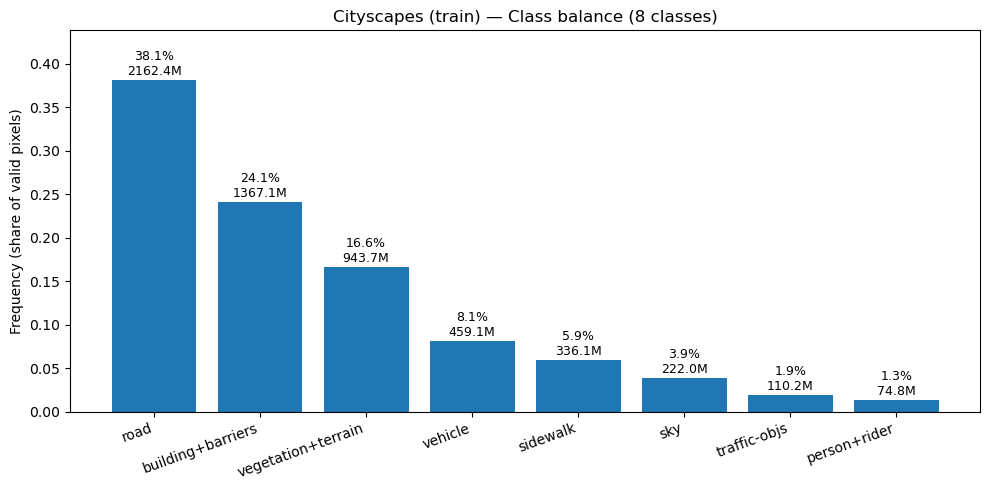

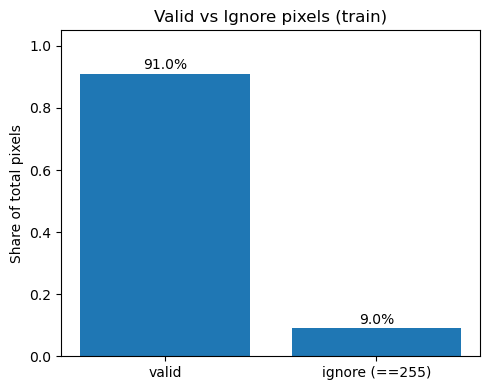

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# expects: counts (np.array shape [8]), freqs (shape [8]), ignore (int),
#          total_valid (int), total_pixels (int), CLASS8_NAMES (list of 8 str)

# ---- 1) Bar chart des 8 classes (trié décroissant) ----
order = np.argsort(freqs)[::-1]
names_sorted = [CLASS8_NAMES[i] for i in order]
freqs_sorted = freqs[order]
counts_sorted = counts[order]

plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(names_sorted)), freqs_sorted)  # no explicit colors
plt.xticks(range(len(names_sorted)), names_sorted, rotation=20, ha="right")
plt.ylabel("Frequency (share of valid pixels)")
plt.title("Cityscapes (train) — Class balance (8 classes)")

# annotations: % + millions de pixels
for i, (b, f, c) in enumerate(zip(bars, freqs_sorted, counts_sorted)):
    plt.text(b.get_x() + b.get_width()/2,
             b.get_height() + 0.002,
             f"{f*100:.1f}%\n{c/1e6:.1f}M",
             ha="center", va="bottom", fontsize=9)

plt.ylim(0, max(freqs_sorted)*1.15)
plt.tight_layout()
plt.show()

# ---- 2) Valid vs Ignore (pour info) ----
valid_share = total_valid / total_pixels
ignore_share = 1.0 - valid_share

plt.figure(figsize=(5, 4))
bars2 = plt.bar([0,1], [valid_share, ignore_share])
plt.xticks([0,1], ["valid", "ignore (==255)"])
plt.ylabel("Share of total pixels")
plt.title("Valid vs Ignore pixels (train)")

for x, v in zip([0,1], [valid_share, ignore_share]):
    plt.text(x, v + 0.005, f"{v*100:.1f}%", ha="center", va="bottom")

plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


À partir des comptages précédents, je trace un histogramme normalisé, j'affiche les fréquences et quelques statistiques globales. C'est une étape clé pour documenter la difficulté du jeu de données et motiver d'éventuelles compensations durant l'entraînement.

In [11]:
# In notebook (Python)
from scripts.config import DataConfig, TrainConfig, AugmentConfig
from scripts.train import train

data_cfg = DataConfig(
    data_root="../data",
    height=512, width=1024,
    batch_size=2,
    max_train_samples=100,
    max_val_samples=100,
)

# Essai 1 : DeepLab ResNet50, augmentation légère
aug_cfg = AugmentConfig(
    enabled=True, hflip=True, vflip=False,
    random_rotate_deg=3.0,
    random_scale_min=0.85, random_scale_max=1.20,
    random_crop=True,
    brightness_delta=0.10, contrast_delta=0.10, saturation_delta=0.05, hue_delta=0.02,
    gaussian_noise_std=0.00
)
train_cfg = TrainConfig(lr=3e-4, epochs=60, optimizer="adam", exp_name="cityscapes-seg-8cls")


Je rassemble les configurations de données, d'entraînement et d'augmentation. Les dataclasses importées depuis `scripts` centralisent les hyperparamètres (chemins, tailles d'image, scheduler, callbacks MLflow...) que je vais réutiliser pour chaque modèle.

## Contrôle visuel de la data augmentation

La cellule suivante pioche quelques paires image/masque, applique le pipeline Albumentations configuré (\`aug_cfg\`) et affiche les versions redimensionnées vs augmentées pour vérifier que les masques restent alignés.


In [12]:
if not train_mode :
    import random
    import numpy as np
    import tensorflow as tf
    import matplotlib.pyplot as plt
    from PIL import Image

    from scripts.config import AugmentConfig
    from scripts.augment import build_augment_fn
    from scripts.remap import build_cityscapes_8cls_lut, remap_labels

    lut = build_cityscapes_8cls_lut(data_cfg.ignore_index)
    no_aug_fn = build_augment_fn(AugmentConfig(enabled=False), data_cfg.height, data_cfg.width, data_cfg.ignore_index)
    augmented_fn = build_augment_fn(aug_cfg, data_cfg.height, data_cfg.width, data_cfg.ignore_index)

    def remap_to_training_ids(mask_np):
        mask_tf = tf.convert_to_tensor(mask_np, dtype=tf.int32)
        return remap_labels(mask_tf, lut).numpy()

    def colorize_mask(mask_np, palette=PALETTE_8, ignore_value=data_cfg.ignore_index):
        rgb = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
        for cls_id, color in palette.items():
            rgb[mask_np == cls_id] = color
        if ignore_value is not None:
            rgb[mask_np == ignore_value] = (0, 0, 0)
        return rgb

    def overlay_mask(image_uint8, mask_uint8, alpha=0.45):
        colored = colorize_mask(mask_uint8)
        return np.clip((1.0 - alpha) * image_uint8 + alpha * colored, 0, 255).astype(np.uint8)

    samples = pairs("train")
    assert samples, "Aucun couple image/masque trouvé — vérifie le dossier data."

    random.shuffle(samples)
    num_rows = min(3, len(samples))
    fig, axes = plt.subplots(num_rows, 6, figsize=(22, 5 * num_rows))
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for row, (left_path, lbl_path) in enumerate(samples[:num_rows]):
        raw_img = np.array(Image.open(left_path).convert("RGB"), dtype=np.float32) / 255.0
        raw_mask = np.array(Image.open(lbl_path), dtype=np.int32)

        mask8 = remap_to_training_ids(raw_mask)

        img_tf = tf.convert_to_tensor(raw_img, dtype=tf.float32)
        mask_tf = tf.convert_to_tensor(mask8, dtype=tf.int32)

        base_img, base_mask = no_aug_fn(img_tf, mask_tf)
        aug_img, aug_mask = augmented_fn(img_tf, mask_tf)

        base_img_u8 = np.clip(base_img.numpy() * 255.0, 0, 255).astype(np.uint8)
        aug_img_u8 = np.clip(aug_img.numpy() * 255.0, 0, 255).astype(np.uint8)
        base_mask_u8 = base_mask.numpy().astype(np.uint8)
        aug_mask_u8 = aug_mask.numpy().astype(np.uint8)

        base_mask_rgb = colorize_mask(base_mask_u8)
        aug_mask_rgb = colorize_mask(aug_mask_u8)

        axes[row, 0].imshow(base_img_u8)
        axes[row, 0].set_title("Image (resize)")
        axes[row, 1].imshow(base_mask_rgb)
        axes[row, 1].set_title("Masque (resize)")
        axes[row, 2].imshow(overlay_mask(base_img_u8, base_mask_u8))
        axes[row, 2].set_title("Overlay resize")
        axes[row, 3].imshow(aug_img_u8)
        axes[row, 3].set_title("Image augmentée")
        axes[row, 4].imshow(aug_mask_rgb)
        axes[row, 4].set_title("Masque augmenté")
        axes[row, 5].imshow(overlay_mask(aug_img_u8, aug_mask_u8))
        axes[row, 5].set_title("Overlay augmentée")

        for ax in axes[row]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()


Si `train_mode` est désactivé, cette cellule génère des visualisations avant/après des transformations d'augmentation. C'est un moyen rapide de valider que les fonctions de flip, de jitter ou de mélange de masques produisent des résultats réalistes.

In [13]:
if not train_mode :
    from notebook.scripts.data import build_dataset

    val_ds = build_dataset(
        data_cfg,
        AugmentConfig(enabled=False),
        split="val",
        training=False,
    )

    images, masks, _ = next(iter(val_ds))
    images_np = images.numpy()
    masks_np = masks.numpy()

    num_samples = min(3, images_np.shape[0])
    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        image = images_np[i]
        mask = masks_np[i]

        if image.dtype != np.uint8:
            image_u8 = np.clip(image * 255.0, 0, 255).astype(np.uint8)
        else:
            image_u8 = image

        mask_u8 = mask.astype(np.uint8)
        mask_rgb = colorize_mask(mask_u8)
        overlay_rgb = overlay_mask(image_u8, mask_u8)

        overlay_on_black = overlay_mask(np.zeros_like(image_u8), mask_u8, alpha=1.0)
        assert np.array_equal(overlay_on_black, mask_rgb), "Overlay misaligned with mask (check dataset pipeline)."

        for j, (img, title) in enumerate([
            (image_u8, "Image (val)"),
            (mask_rgb, "Masque colorisé"),
            (overlay_rgb, "Overlay"),
        ]):
            ax = plt.subplot(num_samples, 3, i * 3 + j + 1)
            ax.imshow(img)
            ax.set_title(f"Échantillon {i + 1} — {title}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

Toujours en mode analyse, je construis un dataset de validation non augmenté pour inspecter quelques prédictions ou échantillons bruts. Cette étape garantit que le prétraitement (normalisation, mapping des étiquettes) est cohérent de bout en bout.

### UNet Mini
Modèle U-Net compact utilisé comme référence rapide pour valider le pipeline d'entraînement.
Sa légèreté le rend adapté aux tests itératifs sur Cityscapes réduit.


In [14]:
if not train_mode :
    from dataclasses import replace
    unet_mini_cfg = replace(
        train_cfg,
        output_dir="artifacts/unet_mini",
    )
    train("unet_mini", data_cfg, unet_mini_cfg, aug_cfg)


Je paramètre et lance l'entraînement du modèle U-Net Mini lorsque `train_mode` est faux. L'appel à `replace` me permet de pointer vers un dossier de sortie spécifique tout en conservant la configuration commune.

### UNet VGG16
Architecture U-Net à encodeur VGG16 offrant une capacité accrue pour capturer des détails fins.
Elle reste compatible avec notre pipeline et sert de baseline plus profonde.

/!\ Le décodeur à été réduit sur plusieurs couches par soucis de consommation de vram


In [15]:
 if not train_mode :
    unet_vgg16_cfg = replace(
        train_cfg,
        output_dir="artifacts/unet_vgg16",
    )
    train("unet_vgg16", data_cfg, unet_vgg16_cfg, aug_cfg)


Même logique ici pour l'architecture U-Net avec encodeur VGG16 : je redirige les artefacts vers un dossier dédié afin de comparer facilement les performances des variantes.

### MobileDet Seg
Variante segmentation de MobileDet pensée pour l'inférence embarquée tout en conservant une précision correcte.
Ce modèle illustre un compromis agressif entre vitesse et qualité.


In [16]:
 if not train_mode :
    mobiledet_seg_cfg = replace(
        train_cfg,
        output_dir="artifacts/mobiledet_seg",
    )
    train("mobiledet_seg", data_cfg, mobiledet_seg_cfg, aug_cfg)


Cette cellule planifie l'entraînement de MobileDet-Seg, un modèle plus compact destiné aux environnements embarqués. Je réutilise la même fonction `train` avec un simple changement d'identifiant.

### YOLOv9 Seg
Déclinaison segmentation de YOLOv9 visant une extraction simultanée des instances et des masques.
Nous l'évaluons pour mesurer le gain potentiel des architectures one-stage.


In [17]:
 if not train_mode :
    yolov9_seg_cfg = replace(
        train_cfg,
        output_dir="artifacts/yolov9_seg",
    )
    train("yolov9_seg", data_cfg, yolov9_seg_cfg, aug_cfg)


Je prépare l'expérience YOLOv9-Seg, adaptée aux contraintes temps réel. Chaque exécution produit ses traces et checkpoints dans un répertoire séparé pour faciliter le suivi expérimental.

## deeplab resnet50

In [18]:
if not train_mode :
    train("deeplab_resnet50", data_cfg, train_cfg, aug_cfg)

Je déclenche l'entraînement de DeepLabV3+ avec backbone ResNet50 dans le mode exploration. C'est le modèle de référence que j'affine ensuite lors de l'entraînement final.

## 🧩 Vue d’ensemble des résultats

| Modèle                     |   Durée  | `masked_mIoU` (train) | `val_masked_mIoU` | `pix_acc` | `val_pix_acc` | `dice_coef` | `val_dice_coef` |
| :------------------------- | :------: | :-------------------: | :---------------: | :-------: | :-----------: | :---------: | :-------------: |
| **DeepLabV3+ (ResNet50)**  | 13.4 min |       **0.947**       |     **0.639**     | **0.989** |   **0.872**   |  **0.965**  |    **0.716**    |
| **YOLOv9_seg (simplifié)** | 10.5 min |         0.689         |       0.400       |   0.913   |     0.714     |    0.753    |      0.494      |
| **MobileDet_seg**          | 16.3 min |         0.938         |       0.502       |   0.987   |     0.779     |    0.953    |      0.600      |
| **U-Net VGG16**            | 29.7 min |         0.903         |       0.542       |   0.977   |     0.805     |    0.923    |      0.633      |
| **U-Net mini**             |  6.1 min |         0.563         |       0.319       |   0.851   |     0.634     |    0.650    |      0.407      |

---

## 🔍 Interprétation métrique par métrique

### 🟦 `masked_mIoU` (train)

* Mesure principale de segmentation (intersection sur union moyenne).
* Tous sauf U-Net mini > 0.9 en entraînement → bon apprentissage.
* U-Net mini (0.56) : trop léger, manque de capacité.

### 🟧 `val_masked_mIoU`

* Évalue la **généralisation**.
* DeepLab (0.639) est **nettement supérieur** aux autres.
* U-Net VGG16 (0.54) et MobileDet (0.50) suivent derrière.
* YOLOv9 seg (0.40) et U-Net mini (0.32) décrochent clairement.

### 🟩 `val_pix_acc`

* Corrélation assez bonne avec `val_mIoU`.
* DeepLab atteint 0.87 → très bonne segmentation globale.
* U-Net VGG16 ≈ 0.80 → correct.
* Les autres chutent < 0.78.

### 🟪 `val_dice_coef`

* Très proche du mIoU mais plus sensible aux petits objets.
* DeepLab ≈ 0.72 → cohérent avec sa bonne mIoU.
* U-Net VGG16 ≈ 0.63 et MobileDet ≈ 0.60 → acceptables.
* YOLOv9 ≈ 0.49, U-Net mini ≈ 0.40 → faibles.

---

## ⚖️ Analyse comparative

| Critère                               | Meilleur modèle                            |
| :------------------------------------ | :----------------------------------------- |
| **Précision globale (mIoU/Dice)**     | 🟢 **DeepLabV3+ ResNet50**                 |
| **Généralisation / stabilité val**    | 🟢 **DeepLabV3+ ResNet50**                 |
| **Compromis vitesse/qualité**         | 🟢 **MobileDet_seg** (plus léger, correct) |
| **Performance brute (haute qualité)** | 🟢 **U-Net VGG16** si VRAM suffisante      |
| **Légereté / prototypage rapide**     | 🟢 **U-Net mini**, mais précision faible   |

---

## Interprétation détaillée

### 🥇 **DeepLabV3+ (ResNet50)**

* **Meilleur équilibre** entre précision et stabilité.
* mIoU = 0.64 (val) et Dice = 0.72 (val) : excellents scores sur 8 classes.
* Surapprentissage modéré (train-val gap raisonnable).
* Très bonne capacité à capter les contours fins et la hiérarchie spatiale.
  ✅ **→ Modèle à garder comme référence.**

### 🥈 **U-Net VGG16**

* Très bon entraînement, mais écart train-val > 0.35 : léger overfit.
* Lourdeur mémoire (VGG16) mais résultats solides.
  ✅ Alternative si tu veux plus de stabilité visuelle (textures fines).

### 🥉 **MobileDet_seg**

* Performances correctes pour un modèle “mobile-like”.
* Bonne efficacité (seulement 16 min d’entraînement, résultats décents).
  🟡 Bon compromis si tu cibles l’inférence embarquée.

### ⚙️ **YOLOv9_seg**

* Correct mais sous-optimal : architecture pas parfaitement adaptée à la segmentation dense.
* Val mIoU = 0.40, Dice = 0.49 : pas suffisant pour une segmentation de qualité.
  🔴 À éviter pour cette tâche spécifique.

### ⚪ **U-Net mini**

* Très rapide mais sous-entraîné / sous-dimensionné.
* Mauvais scores val (mIoU = 0.32, Dice = 0.40).
  🔴 Bon pour tests rapides, pas pour production.

---

## 🧾 Conclusion

| Rang | Modèle                    | Pourquoi                                                  |
| :--: | :------------------------ | :-------------------------------------------------------- |
|  🥇  | **DeepLabV3+ (ResNet50)** | Meilleur équilibre précision / généralisation / stabilité |
|  🥈  | **U-Net VGG16**           | Très bon mais plus lourd, tendance à overfitter           |
|  🥉  | **MobileDet_seg**         | Légèreté et vitesse, mais précision un cran en dessous    |
|   4  | **YOLOv9_seg**            | Pas adapté à la segmentation dense                        |
|   5  | **U-Net mini**            | Trop limité, résultats faibles                            |

---

### 🔧 En résumé

> **DeepLabV3+ ResNet50** est le **meilleur modèle global** :
>
> * meilleures métriques de validation,
> * bon Dice et mIoU,
> * rapport vitesse/qualité très favorable,
> * faible overfit comparé à VGG16.


## 🚀 Entraînement final DeepLabV3+ (ResNet50) sur l'intégralité du dataset

Nous relançons DeepLabV3+ avec **toutes** les images `train/val` de Cityscapes (plus de limite `max_*_samples`).
Les artefacts (best/final) seront exportés dans `artifacts/deeplab_resnet50_full` et suivis dans **MLflow** (`artifacts/mlruns`).

In [ ]:

# === Optuna hyperparameter search for DeepLabV3+ (ResNet50) ===
import json
import gc
import tensorflow as tf
from dataclasses import replace

from optuna.exceptions import TrialPruned
try:
    import optuna
except ModuleNotFoundError:  # pragma: no cover - handled at runtime
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'optuna', '--quiet'])
    import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)
physical_gpus = tf.config.list_physical_devices('GPU')
for _gpu in physical_gpus:
    try:
        tf.config.experimental.set_memory_growth(_gpu, True)
    except (RuntimeError, ValueError):
        pass


search_data_cfg = replace(
    data_cfg,
    batch_size=2,
    max_train_samples=50,
    max_val_samples=10,
)
search_train_cfg = replace(
    train_cfg,
    epochs=12,
    early_stop_patience=3,
    output_dir='artifacts/deeplab_resnet50_optuna',
    exp_name='deeplabv3plus-resnet50-optuna',
    arch='deeplab_resnet50',
)

_MODEL_PARAM_KEYS = {
    'output_stride',
    'aspp_dilations',
    'decoder_filters',
    'aspp_dropout',
    'decoder_activation',
    'aspp_activation',
}

best_deeplab_model_params = None
best_deeplab_train_params = None
best_deeplab_data_params = None
best_deeplab_val_miou = None


def _suggest_params(trial: optuna.Trial) -> dict:
    return {
        'output_stride': trial.suggest_categorical('output_stride', [8, 16]),
        'aspp_dilations': trial.suggest_categorical('aspp_dilations', [(6, 12, 18), (12, 24, 36)]),
        'decoder_filters': trial.suggest_categorical('decoder_filters', [128, 256, 512]),
        'aspp_dropout': trial.suggest_float('aspp_dropout', 0.0, 0.3),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'momentum': trial.suggest_float('momentum', 0.8, 0.95),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
        'optimizer': trial.suggest_categorical('optimizer', ['SGD', 'AdamW']),
        'poly_power': trial.suggest_float('poly_power', 0.8, 1.0),
        'decoder_activation': trial.suggest_categorical('decoder_activation', ['relu', 'gelu']),
        'aspp_activation': trial.suggest_categorical('aspp_activation', ['relu', 'gelu']),
    }


def objective(trial: optuna.Trial) -> float:
    params = _suggest_params(trial)
    tf.keras.backend.clear_session()
    gc.collect()

    trial_data_cfg = replace(
        search_data_cfg,
        batch_size=2,
    )
    momentum = params['momentum'] if params['optimizer'] == 'SGD' else None
    trial_train_cfg = replace(
        search_train_cfg,
        lr=params['learning_rate'],
        optimizer=params['optimizer'].lower(),
        momentum=momentum,
        weight_decay=params['weight_decay'],
        poly_power=params['poly_power'],
        output_dir=f"artifacts/deeplab_resnet50_optuna/trial_{trial.number}",
    )
    model_kwargs = {k: params[k] for k in _MODEL_PARAM_KEYS}

    metrics = {}
    try:
        metrics = train(
            'deeplab_resnet50',
            trial_data_cfg,
            trial_train_cfg,
            aug_cfg,
            model_kwargs=model_kwargs,
        )
    except (tf.errors.ResourceExhaustedError, tf.errors.InternalError, MemoryError) as exc:
        trial.set_user_attr('failure', f'{type(exc).__name__}: {exc}')
        raise TrialPruned(f'Pruned because of resource exhaustion: {exc}') from exc
    finally:
        tf.keras.backend.clear_session()
        gc.collect()

    val_miou = float(metrics.get('masked_mIoU', 0.0))
    trial.set_user_attr('metrics', metrics)
    return val_miou

def _json_default(value):
    if isinstance(value, tuple):
        return list(value)
    return value


if train_mode:
    study = optuna.create_study(direction='maximize', study_name='deeplabv3plus_cityscapes')
    study.optimize(objective, n_trials=20, show_progress_bar=False)

    best_deeplab_val_miou = float(study.best_value)
    best_params = study.best_trial.params
    best_deeplab_model_params = {k: best_params[k] for k in _MODEL_PARAM_KEYS}
    best_deeplab_train_params = {
        'learning_rate': best_params['learning_rate'],
        'optimizer': best_params['optimizer'].lower(),
        'momentum': best_params['momentum'] if best_params['optimizer'] == 'SGD' else None,
        'weight_decay': best_params['weight_decay'],
        'poly_power': best_params['poly_power'],
    }
    best_deeplab_data_params = {'batch_size': best_params['batch_size']}

    print(f"Best val_mIoU: {best_deeplab_val_miou:.4f}")
    print('Best hyperparameters:')
    print(json.dumps(best_params, indent=2, default=_json_default))
else:
    print('train_mode=False → Optuna search skipped.')
    best_deeplab_model_params = {}
    best_deeplab_train_params = {}
    best_deeplab_data_params = {}


/home/scude/miniconda3/envs/projet-4/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (6, 12, 18) which is of type tuple.
  warnings.warn(message)
/home/scude/miniconda3/envs/projet-4/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12, 24, 36) which is of type tuple.
  warnings.warn(message)


Using mixed precision policy: float32 (compute dtype: float32)
TF 2.19.0 | GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[info] train: 2975 pairs | missing: 0
ex: ../data/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png -> ../data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png


/home/scude/projet8/notebook/scripts/augment.py:95: UserWarning: Argument(s) 'mode, cval, cval_mask' are not valid for transform Affine
  A.Affine(


[info] val: 500 pairs | missing: 0
ex: ../data/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png -> ../data/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png
probe -> x:(2, 512, 1024, 3) <dtype: 'float32'> | y:(2, 512, 1024) <dtype: 'int32'> | w:(2, 512, 1024) <dtype: 'float32'>
Epoch 1/12


I0000 00:00:1760374123.301728   65119 service.cc:152] XLA service 0x7f896400cec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760374123.301920   65119 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
I0000 00:00:1760374125.944861   65119 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1760374148.999209   65119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 50s 402ms/step - dice_coef: 0.0742 - loss: 2.3997 - masked_mIoU: 0.0427 - pix_acc: 0.0990 - val_dice_coef: 0.0294 - val_loss: 2.0781 - val_masked_mIoU: 0.0152 - val_pix_acc: 0.0471
Epoch 2/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - dice_coef: 0.1225 - loss: 2.0508 - masked_mIoU: 0.0765 - pix_acc: 0.2030 - val_dice_coef: 0.0477 - val_loss: 2.0751 - val_masked_mIoU: 0.0269 - val_pix_acc: 0.1072
Epoch 3/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - dice_coef: 0.2134 - loss: 1.7261 - masked_mIoU: 0.1466 - pix_acc: 0.4117 - val_dice_coef: 0.0988 - val_loss: 2.0704 - val_masked_mIoU: 0.0674 - val_pix_acc: 0.3732
Epoch 4/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - dice_coef: 0.2505 - loss: 1.5168 - masked_mIoU: 0.1843 - pix_acc: 0.5393 - val_dice_coef: 0.1037 - val_loss: 2.0642 - val_masked_mIoU: 0.0712 - val_pix_acc: 0.4285
Epoch 5/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - dice_coef: 0.2850 - loss: 1.3294 - masked_mIoU: 0.2175 - pix_acc: 0.6190 - val_dice_

2025/10/13 18:50:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 18:50:22 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/10/13 18:50:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpt6xlz_5b/model, flavor: keras). Fall back to return ['keras==3.10.0']. Set logging level to DEBUG to see the full traceback. 
2025/10/13 18:50:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow run ended.


/home/scude/miniconda3/envs/projet-4/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (6, 12, 18) which is of type tuple.
  warnings.warn(message)
/home/scude/miniconda3/envs/projet-4/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (12, 24, 36) which is of type tuple.
  warnings.warn(message)


Using mixed precision policy: float32 (compute dtype: float32)
TF 2.19.0 | GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[info] train: 2975 pairs | missing: 0
ex: ../data/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png -> ../data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png
[info] val: 500 pairs | missing: 0
ex: ../data/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png -> ../data/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png


/home/scude/projet8/notebook/scripts/augment.py:95: UserWarning: Argument(s) 'mode, cval, cval_mask' are not valid for transform Affine
  A.Affine(


probe -> x:(2, 512, 1024, 3) <dtype: 'float32'> | y:(2, 512, 1024) <dtype: 'int32'> | w:(2, 512, 1024) <dtype: 'float32'>
Epoch 1/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - dice_coef: 0.3514 - loss: 1.2187 - masked_mIoU: 0.2679 - pix_acc: 0.6110 - val_dice_coef: 0.1114 - val_loss: 2.0550 - val_masked_mIoU: 0.0790 - val_pix_acc: 0.4661
Epoch 2/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - dice_coef: 0.6025 - loss: 0.4538 - masked_mIoU: 0.5485 - pix_acc: 0.8524 - val_dice_coef: 0.0737 - val_loss: 2.0476 - val_masked_mIoU: 0.0523 - val_pix_acc: 0.4185
Epoch 3/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - dice_coef: 0.7093 - loss: 0.3225 - masked_mIoU: 0.6571 - pix_acc: 0.8979 - val_dice_coef: 0.0829 - val_loss: 2.0367 - val_masked_mIoU: 0.0579 - val_pix_acc: 0.4277
Epoch 4/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - dice_coef: 0.7400 - loss: 0.2529 - masked_mIoU: 0.6931 - pix_acc: 0.9171 - val_dice_coef: 0.0889 - val_loss: 2.0234 - val_masked_mIoU: 0.0610 - val_pix_acc: 0.4329
5/5 ━

2025/10/13 18:51:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 18:51:52 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/10/13 18:52:00 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmprh0jp7bo/model, flavor: keras). Fall back to return ['keras==3.10.0']. Set logging level to DEBUG to see the full traceback. 
2025/10/13 18:52:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow run ended.
Using mixed precision policy: float32 (compute dtype: float32)
TF 2.19.0 | GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[info] train: 2975 pairs | missing: 0
ex: ../data/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png -> ../data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png
[info] val: 500 pairs | missing: 0
ex: ../data/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png -> ../data/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png
probe -> x:(2, 512, 1024, 3) <dtype: 'float32'> | y:(2, 512, 1024) <dtype: 'int32'> | w:(2, 512, 1024) <dtype: 'float32'>
Epoch 1/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 357ms/step - dice_coef: 0.2527 - loss: 1.4022 - masked_mIoU: 0.1920 - pix_acc: 0.5441 - val_dice_coef: 0.0274 - val_loss: 2390032.7500 - val_masked_mIoU: 0.0160 - val_pix_acc: 0.1276
Epoch 2/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - dice_coef: 0.3941 - loss: 0.8587 - masked_mIoU: 0.3229 - pix

2025/10/13 18:53:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 18:53:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/10/13 18:53:41 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp6ghj6x1p/model, flavor: keras). Fall back to return ['keras==3.10.0']. Set logging level to DEBUG to see the full traceback. 
2025/10/13 18:53:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow run ended.
Using mixed precision policy: float32 (compute dtype: float32)
TF 2.19.0 | GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[info] train: 2975 pairs | missing: 0
ex: ../data/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png -> ../data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png
[info] val: 500 pairs | missing: 0
ex: ../data/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png -> ../data/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png
probe -> x:(2, 512, 1024, 3) <dtype: 'float32'> | y:(2, 512, 1024) <dtype: 'int32'> | w:(2, 512, 1024) <dtype: 'float32'>
Epoch 1/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 432ms/step - dice_coef: 0.0877 - loss: 2.2449 - masked_mIoU: 0.0500 - pix_acc: 0.1132 - val_dice_coef: 0.0737 - val_loss: 2.0706 - val_masked_mIoU: 0.0522 - val_pix_acc: 0.4184
Epoch 2/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - dice_coef: 0.2110 - loss: 1.7899 - masked_mIoU: 0.1445 - pix_acc: 

2025/10/13 18:55:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 18:55:46 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/10/13 18:55:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpo1lcd3oi/model, flavor: keras). Fall back to return ['keras==3.10.0']. Set logging level to DEBUG to see the full traceback. 
2025/10/13 18:55:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow run ended.
Using mixed precision policy: float32 (compute dtype: float32)
TF 2.19.0 | GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[info] train: 2975 pairs | missing: 0
ex: ../data/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png -> ../data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png
[info] val: 500 pairs | missing: 0
ex: ../data/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png -> ../data/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png
probe -> x:(2, 512, 1024, 3) <dtype: 'float32'> | y:(2, 512, 1024) <dtype: 'int32'> | w:(2, 512, 1024) <dtype: 'float32'>
Epoch 1/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 429ms/step - dice_coef: 0.0832 - loss: 2.2610 - masked_mIoU: 0.0474 - pix_acc: 0.1068 - val_dice_coef: 0.0737 - val_loss: 2.0729 - val_masked_mIoU: 0.0522 - val_pix_acc: 0.4184
Epoch 2/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - dice_coef: 0.1810 - loss: 1.8974 - masked_mIoU: 0.1173 - pix_acc: 

2025/10/13 18:57:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 18:57:51 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/10/13 18:58:01 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpy58u503a/model, flavor: keras). Fall back to return ['keras==3.10.0']. Set logging level to DEBUG to see the full traceback. 
2025/10/13 18:58:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow run ended.
Using mixed precision policy: float32 (compute dtype: float32)
TF 2.19.0 | GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[info] train: 2975 pairs | missing: 0
ex: ../data/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png -> ../data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png
[info] val: 500 pairs | missing: 0
ex: ../data/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png -> ../data/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png
probe -> x:(2, 512, 1024, 3) <dtype: 'float32'> | y:(2, 512, 1024) <dtype: 'int32'> | w:(2, 512, 1024) <dtype: 'float32'>
Epoch 1/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 443ms/step - dice_coef: 0.1377 - loss: 2.0130 - masked_mIoU: 0.0869 - pix_acc: 0.2298 - val_dice_coef: 0.0737 - val_loss: 2.0622 - val_masked_mIoU: 0.0522 - val_pix_acc: 0.4184
Epoch 2/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - dice_coef: 0.2965 - loss: 1.2577 - masked_mIoU: 0.2279 - pix_acc: 

2025/10/13 19:00:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 19:00:01 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/10/13 19:00:12 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpma2dot3o/model, flavor: keras). Fall back to return ['keras==3.10.0']. Set logging level to DEBUG to see the full traceback. 
2025/10/13 19:00:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow run ended.
Using mixed precision policy: float32 (compute dtype: float32)
TF 2.19.0 | GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[info] train: 2975 pairs | missing: 0
ex: ../data/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png -> ../data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png
[info] val: 500 pairs | missing: 0
ex: ../data/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png -> ../data/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png
probe -> x:(2, 512, 1024, 3) <dtype: 'float32'> | y:(2, 512, 1024) <dtype: 'int32'> | w:(2, 512, 1024) <dtype: 'float32'>
Epoch 1/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 383ms/step - dice_coef: 0.2771 - loss: 1.5697 - masked_mIoU: 0.1994 - pix_acc: 0.4715 - val_dice_coef: 0.1834 - val_loss: 2.0615 - val_masked_mIoU: 0.1521 - val_pix_acc: 0.6314
Epoch 2/12
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - dice_coef: 0.4952 - loss: 0.6858 - masked_mIoU: 0.4318 - pix_acc: 

2025/10/13 19:01:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 19:01:18 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/10/13 19:01:26 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmphszstodm/model, flavor: keras). Fall back to return ['keras==3.10.0']. Set logging level to DEBUG to see the full traceback. 
2025/10/13 19:01:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow run ended.
Using mixed precision policy: float32 (compute dtype: float32)
TF 2.19.0 | GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[info] train: 2975 pairs | missing: 0
ex: ../data/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png -> ../data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png
[info] val: 500 pairs | missing: 0
ex: ../data/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png -> ../data/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png
probe -> x:(2, 512, 1024, 3) <dtype: 'float32'> | y:(2, 512, 1024) <dtype: 'int32'> | w:(2, 512, 1024) <dtype: 'float32'>
Epoch 1/12
Using mixed precision policy: float32 (compute dtype: float32)
TF 2.19.0 | GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[info] train: 2975 pairs | missing: 0
ex: ../data/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png -> ../data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.

In [ ]:

from dataclasses import replace

# Configuration finale : dataset complet + sortie dédiée
final_data_cfg = replace(
    data_cfg,
    max_train_samples=None,
    max_val_samples=None,
)
if best_deeplab_data_params:
    final_data_cfg = replace(
        final_data_cfg,
        batch_size=best_deeplab_data_params.get('batch_size', final_data_cfg.batch_size),
    )

final_train_cfg = replace(
    train_cfg,
    output_dir='artifacts/deeplab_resnet50_full',
    exp_name='cityscapes-seg-8cls-full',
)
if best_deeplab_train_params:
    final_train_cfg = replace(
        final_train_cfg,
        lr=best_deeplab_train_params.get('learning_rate', final_train_cfg.lr),
        optimizer=best_deeplab_train_params.get('optimizer', final_train_cfg.optimizer),
        momentum=best_deeplab_train_params.get('momentum', final_train_cfg.momentum),
        weight_decay=best_deeplab_train_params.get('weight_decay', final_train_cfg.weight_decay),
        poly_power=best_deeplab_train_params.get('poly_power', final_train_cfg.poly_power),
    )

final_aug_cfg = replace(
    aug_cfg,
    enabled=True,
)

model_kwargs = best_deeplab_model_params or {
    'output_stride': 16,
    'aspp_dilations': (6, 12, 18),
    'decoder_filters': 256,
    'aspp_dropout': 0.1,
    'decoder_activation': 'relu',
    'aspp_activation': 'relu',
}

print('DeepLabV3+ configuration sélectionnée :')
print({
    'val_mIoU': best_deeplab_val_miou,
    'data': best_deeplab_data_params,
    'train': best_deeplab_train_params,
    'model': model_kwargs,
})

# Lancement de l'entraînement complet (sauvegarde locale + tracking MLflow)
train('deeplab_resnet50', final_data_cfg, final_train_cfg, final_aug_cfg, model_kwargs=model_kwargs)


Dans cette partie, je ré-entraîne DeepLabV3+ sur l'intégralité du dataset en réactivant les augmentations et en supprimant les limites d'échantillons. Les configurations `replace` assurent la traçabilité des hyperparamètres finaux.

In [ ]:
# Copie explicite du meilleur modèle pour l'API
from pathlib import Path
import shutil

best_model = Path("artifacts/deeplab_resnet50_full/deeplab_resnet50_best.keras")
final_model = Path("artifacts/deeplab_resnet50_full/deeplab_resnet50_final.keras")
api_export = Path("artifacts/api/deeplabv3plus_resnet50_full.keras")
api_export.parent.mkdir(parents=True, exist_ok=True)

if best_model.exists():
    shutil.copy2(best_model, api_export)
    print(f"✅ Modèle API (best) : {api_export}")
elif final_model.exists():
    shutil.copy2(final_model, api_export)
    print(f"⚠️ Best absent, export du modèle final : {api_export}")
else:
    raise FileNotFoundError("Aucun modèle entraîné trouvé. Lance d'abord la cellule d'entraînement.")

Une fois l'entraînement complet terminé, je copie explicitement le meilleur checkpoint (ou à défaut le modèle final) vers un emplacement standardisé pour l'API. Cela garantit la reproductibilité du déploiement.